Copyright (C) Egon Kidmose 2015-2018

This file is part of lstm-rnn-correlation.

lstm-rnn-correlation is free software: you can redistribute it and/or
modify it under the terms of the GNU Lesser General Public License as
published by the Free Software Foundation, either version 3 of the
License, or (at your option) any later version.

lstm-rnn-correlation is distributed in the hope that it will be
useful, but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
Lesser General Public License for more details.

You should have received a copy of the GNU Lesser General Public
License along with lstm-rnn-correlation. If not, see
<http://www.gnu.org/licenses/>.

# Clean flows

 1. Loads flows from multiple CSV
 2. Handle some error found in the data
 3. Plot for validation against rules derived from webpage
 4. Save to a single csv
 
## Oddities:

 1. Timestamp format is inconsistent across files
 2. Timestamp is in 12hr format, but AM/PM is not included
 3. Inconsistency between labels/timestamps in CSV and data description:
  * Flows for Botnet in CSV has timestamps from ~10:00 a.m. to ~1:00 p.m.
  * Documentation reads 10:02 a.m. - 11:02 a.m.
  * **NOT HANDLED HERRE**

In [1]:
from lstm_rnn_tied_weights import util

import pandas as pd
import numpy as np
import glob
from datetime import datetime
from datetime import timedelta
import os
import re

# matplotlib
try: # might, might not have x available
    import os
    os.environ['DISPLAY']
except KeyError:
    import matplotlib
    matplotlib.use('Agg')
try: # might, might not be notebook
    %matplotlib inline
except NameError:
    pass
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/home/egk/git-reps/lstm-rnn-correlation/venv/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
logger = util.get_logger('clean-flows')

output_prefix = os.path.join('output', 'clean-flows-'+util.get_runid(), util.get_runid()+'-')
if not os.path.exists('output'):
    os.mkdir('output')
if not os.path.exists(os.path.dirname(output_prefix)):
    os.mkdir(os.path.dirname(output_prefix))

Output prefix: log/clean-flows-20180716-204712-egk-aau-laptop/20180716-204712-egk-aau-laptop-


## Parse flows from CSVs

In [3]:
# Verify existing
!cd ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/; find  -iname '*.md5' -print0 | sort -z | xargs -0 -n1 bash -c 'cat ${0}; md5sum --check ${0}'
# extract
!cd ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/; unzip -o CSVs.zip -d CSVs
# checksum extracted CSVs
!cd ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs; sha256sum *
# pandas can't parse u"Infinity" as a float. Replacing with u"inf". https://github.com/pandas-dev/pandas/issues/10065
!sed -i'' 's/,Infinity,/,Inf,/g' ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/*.csv
# Remove spaces leading fields
!sed -i'' 's/, /,/g' ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/*.csv
# Remove rows with fields empty
!sed -i'' '/^,\{84\}\s\?$/d' ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/*.csv
# checksum extracted CSVs, with above changes
!cd ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs; sha256sum *

cat: bash: No such file or directory
md5sum: bash: No such file or directory
unzip:  cannot find or open CSVs.zip, CSVs.zip.zip or CSVs.zip.ZIP.
7f02d9378e99d7d38254f63b7a67a8e2906201bad9b90b3005608472c7ca5e50  Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
84fb712c5215ad1865e6d83be31a9b9f99e65d7a9647bcf6810a6751fd611c16  Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
69b1727ee3c0f4013388f42216aa39a62bef709c976b929c125a28bfdc7398a1  Friday-WorkingHours-Morning.pcap_ISCX.csv
64b51c2bb54699c4f1376a42a37bda27f43572d30efa006939253ae5cfe6bdad  Monday-WorkingHours.pcap_ISCX.csv
311b7c13f058828f4258ca31b9f2c06c9bd2d33a14e1fa5e2258769ae822aed1  Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
a9b349a9c06b7b6af9dae17498bd60080c7397277ebe38caf757325462c5992b  Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
bc8796f601622e434a639441f0b2755329caa176116a1d48105e64534ac865fe  Tuesday-WorkingHours.pcap_ISCX.csv
5328925029e5bf3537f1181d98bb9359309b4a4b1a007b7ab924c0d8d0b05eef 

In [4]:
# Load flow data from CSV

files = [
    '../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Monday-WorkingHours.pcap_ISCX.csv',
    '../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Tuesday-WorkingHours.pcap_ISCX.csv',
    '../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Wednesday-workingHours.pcap_ISCX.csv',
    '../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    '../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    '../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Friday-WorkingHours-Morning.pcap_ISCX.csv',
    '../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    '../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
]

flows = {}

for f in files:
    logger.info(u"Loading %s .." % f)
    df = pd.read_csv(
        f,
        dtype={
            'External IP': 'S15',
        },
        usecols=[
            'Flow ID',
            'Source IP',
            'Source Port',
            'Destination IP',
            'Destination Port',
            'Protocol',
            'Timestamp',
            'Flow Duration',
            'Label',
            'Total Fwd Packets',
            'Total Backward Packets',
        ],
        encoding='cp1252',
    )
    logger.info(df.shape)
    flows[os.path.basename(f)] = df
total_flows_loaded = sum([flow.shape[0] for flow in flows.values()])
logger.info('flows loaded: %d' % total_flows_loaded)

for f in flows:
    # line number as a column
    flows[f] = flows[f].reset_index().rename(columns={'index': 'LineNumber'})
    flows[f].LineNumber = flows[f].LineNumber + 1
    # replace non-ascii long dash
    flows[f]['Label'] = flows[f].Label.map(lambda label : label.replace(u'\u2013', '-'))    

Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Monday-WorkingHours.pcap_ISCX.csv ..
(529918, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Tuesday-WorkingHours.pcap_ISCX.csv ..
(445909, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Wednesday-workingHours.pcap_ISCX.csv ..
(692703, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv ..
(170366, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv ..
(288602, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Friday-WorkingHours-Morning.pcap_ISCX.csv ..
(191033, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/CSVs/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv ..
(286467, 11)
Loading ../../data/iscxdownloads.cs.unb.ca/iscx

In [5]:
# Parse timestamp
def strptime(s):
    """
    Parse timestamp, handling intermittent zero-padding and omission of seconds.
    """
    r = re.compile('^(?P<day>[0-9]{1,2})/(?P<month>[0-9]{1,2})/(?P<year>[0-9]{4}) (?P<hour>[0-9]{1,2}):(?P<minute>[0-9]{2})(?::(?P<second>[0-9]{2}))?(?P<remainder>.+)?$')
    m = r.match(s)
    if m is None:
        raise ValueError('No match on %s' % s)
    d = m.groupdict()
    if d['remainder'] is not None:
        raise ValueError('Remainder is not None for \'%s\': %s' % (s, str(d)))
    d.pop('remainder')
    if d['second'] is None:
        d.pop('second') # Seconds are optional
    return datetime(**{k: int(v) for k, v in d.items()})

assert strptime('7/7/2017 8:59') == datetime(2017, 7, 7, 8, 59) # No zeropad, no seconds
assert strptime('03/07/2017 08:55:58') == datetime(2017, 7, 3, 8, 55, 58) # Zeropad, seconds

for f in flows:
    if not 'TimestampStr' in flows[f].columns:
        flows[f] = flows[f].rename(columns={'Timestamp':'TimestampStr'})
    flows[f]['Timestamp'] = flows[f].TimestampStr.map(strptime)
    

In [6]:
# repair info missing because PM is truncated to AM
for f in flows:
    if 'Monday-WorkingHours.pcap_ISCX.csv' in f:
        offset = (flows[f].Timestamp < pd.to_datetime('2017-07-03 08:30')) * pd.to_timedelta('12H')
        flows[f]['Timestamp'] = flows[f]['Timestamp'] + offset
    if 'Tuesday-WorkingHours.pcap_ISCX.csv' in f:
        offset = (flows[f].Timestamp < pd.to_datetime('2017-07-04 08:30')) * pd.to_timedelta('12H')
        flows[f]['Timestamp'] = flows[f]['Timestamp'] + offset
    if 'Wednesday-workingHours.pcap_ISCX.csv' in f:
        offset = (flows[f].Timestamp < pd.to_datetime('2017-07-05 08:30')) * pd.to_timedelta('12H')
        flows[f]['Timestamp'] = flows[f]['Timestamp'] + offset
    if 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv' in f:
        flows[f]['Timestamp'] = flows[f]['Timestamp'] + pd.to_timedelta('12H')
    if 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv' in f:
        flows[f]['Timestamp'] = flows[f]['Timestamp'] + pd.to_timedelta('12H')
    if 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv' in f:
        flows[f]['Timestamp'] = flows[f]['Timestamp'] + pd.to_timedelta('12H')

In [7]:
for f in flows:
    # Parse Flow duration 
    # By comparing 192.168.10.15:52772 <-> 1.1.70.73:80 TCP from pcap and csv => unit is microseconds
    flows[f]['Flow Duration'] = flows[f]['Flow Duration'].map(
        lambda i: timedelta(seconds=float(i)/1e6)
    )
    # Calculate flow end
    flows[f]['TimestampEnd'] = flows[f]['Timestamp'] + flows[f]['Flow Duration']

## Load rules derived from web page

In [8]:
# load incident descriptions, extracted from website text
inc_desc = pd.read_csv(
    'incident_descriptions.csv', 
    parse_dates=['Start', 'Stop'],
    date_parser = lambda x: pd.datetime.strptime(x, '%d-%m-%y %H:%M')
)
inc_desc['Stop'] = inc_desc['Stop'].dt.floor('min') + timedelta(minutes=1)
inc_desc['Interval'] = inc_desc[['Start', 'Stop',]].apply(
    lambda d: pd.Interval(d[0], d[1], closed='both'), 
    axis=1
)

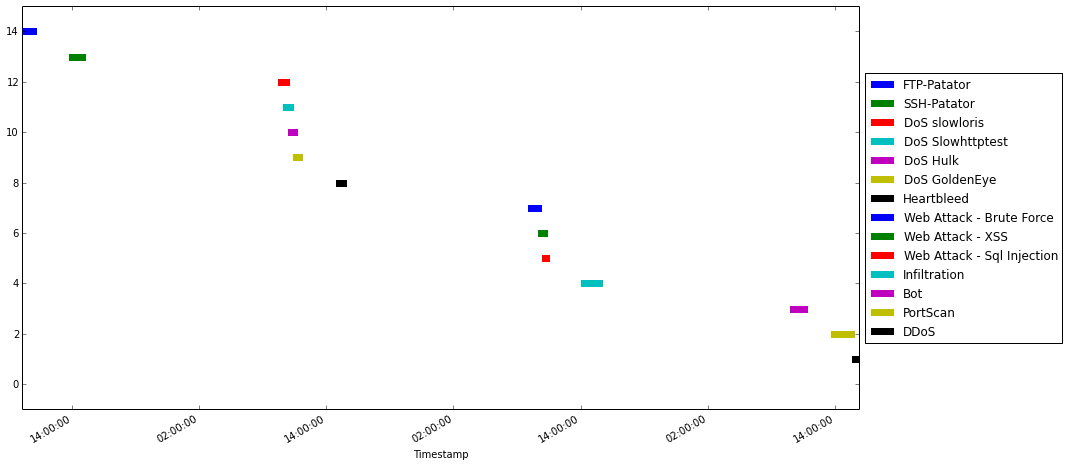

In [9]:
# plot description from webpage

# Flat (i.e. start and stop in same column)
inc_desc_flat = pd.concat([
    inc_desc.rename(columns={'Start': 'Timestamp'}),
    inc_desc.rename(columns={'Stop': 'Timestamp'}),
])

begin = inc_desc_flat.groupby('Label').Timestamp.min().sort_values()
end =  inc_desc_flat.groupby('Label').Timestamp.max()

# create an index containing all min and max timestamps
df_periods = pd.DataFrame(index=pd.Index(pd.concat([begin, end,])))

# create a (constant) Series for each series
for idx, d in enumerate(begin.index):
    df_periods[d] = df_periods.index.to_series().apply(
        lambda x: begin.shape[0] - idx if x >= begin[d] and x <= end[d] else np.NaN
    )

ax = df_periods.plot(
    ylim=[-1, begin.shape[0]+1],
    xlim=[begin.min(), end.max()],
    linewidth=7,
    legend=True,
    figsize=(15, 8),
)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Store colors for reuse
colors = {line.get_label(): line.get_color() for line in ax.lines}
colors['BENIGN'] = '#808080' # Benign is not in rules..

## Plot for comparison

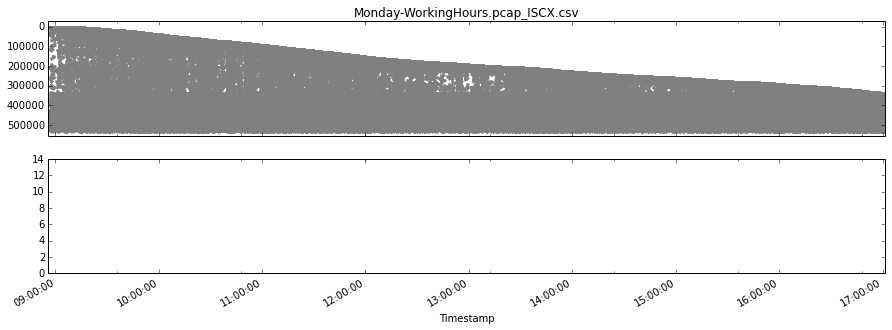

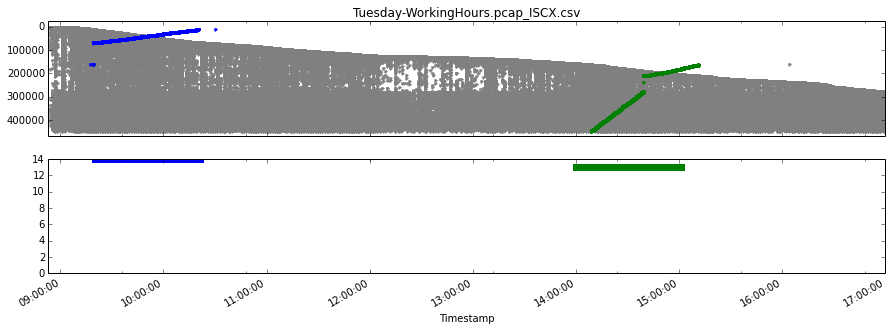

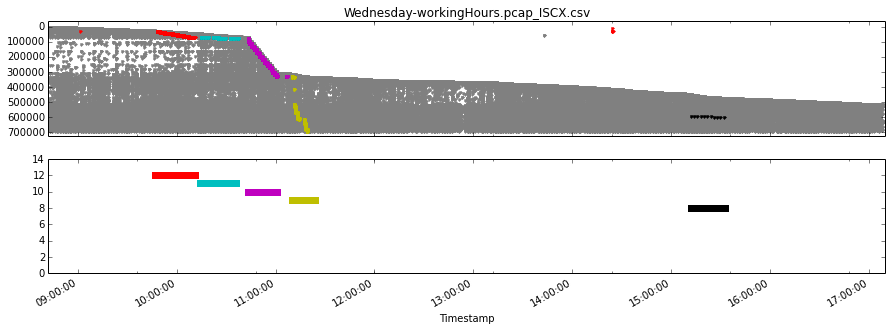

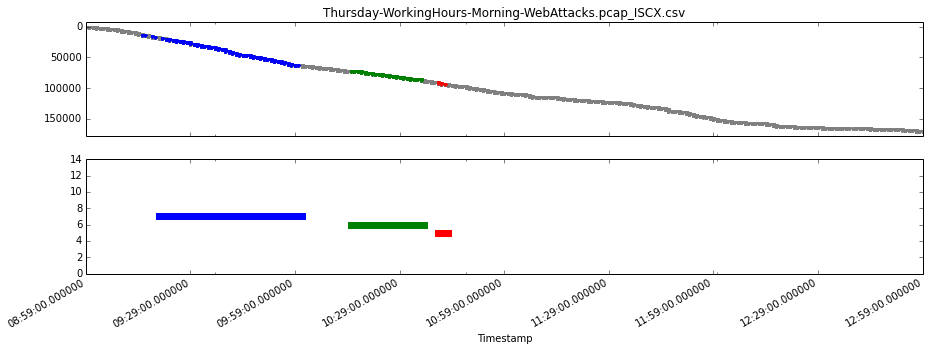

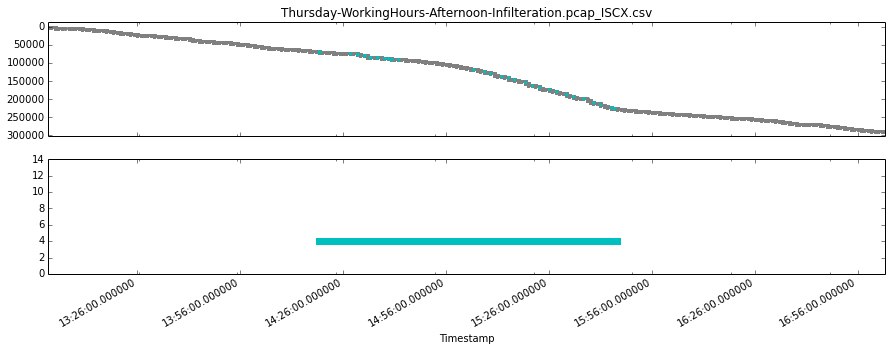

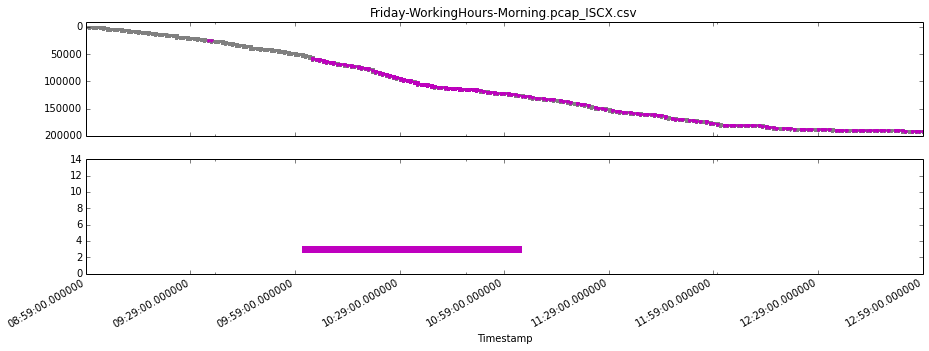

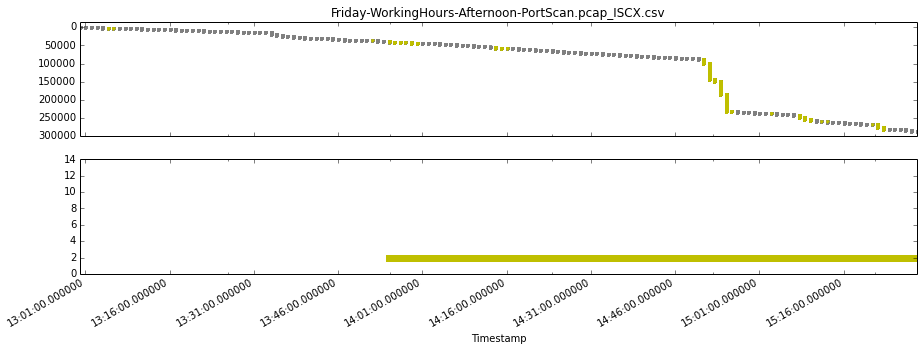

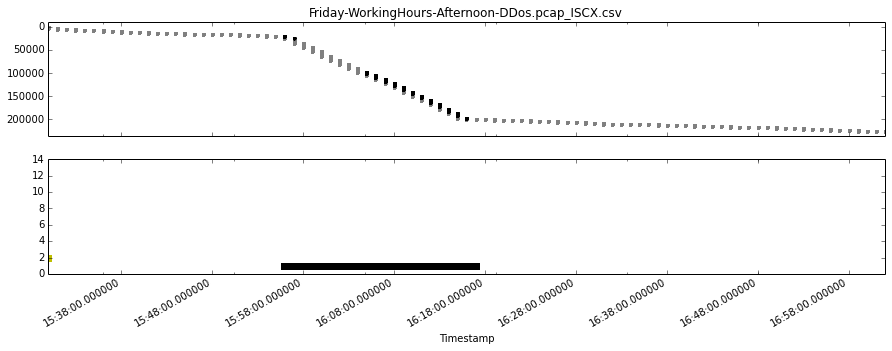

In [10]:
# Plot line number vs timestamp + rules from files
for f in files:
    f = os.path.basename(f)
    df = flows[f]
    fig, axes = plt.subplots(nrows=2, figsize=(15, 5), sharex=True)
    
    # Plot rules
    df_periods.plot(
        linewidth=7,
        ax=axes[1],
        legend=False,
    )
    
    # Plot flows
    groups = df.reset_index().groupby('Label')[['Timestamp', 'LineNumber']]
    
    df.reset_index().set_index('Timestamp').groupby('Label')['index'].plot(
        marker='.',
        linestyle='None',
        ax=axes[0],
    )
    
    # Fix colours
    for line in axes[0].lines:
        line.set_color(colors[line.get_label()])
    
    # Shared 
    
    axes[0].set_title(f)
    axes[0].margins(0.05) # Set limits by 
    axes[0].set_ylim(reversed(axes[0].get_ylim())) # Line number ax invernted
    

## Export

In [11]:
OUTFILE = output_prefix + 'clean-flows.csv'

for f in files:
    f = os.path.basename(f)
    df = flows[f]
    df = df.drop(['Flow ID', 'TimestampStr'], axis='columns')
    df['Filename'] = f
    df.to_csv(
        OUTFILE,
        mode='w+',
        index=False,
    )

logger.info('Saved flows to %s' % OUTFILE)

Saved flows to output/clean-flows-20180716-204712-egk-aau-laptop/20180716-204712-egk-aau-laptop-clean-flows.csv
